In [1]:
import torch
from itertools import combinations
import numpy as np
import torch.nn.functional as F
from typing import List, Tuple, Dict, Any
import matplotlib.pyplot as plt

In [2]:
from fuzz.utils import enumerate_permute, gap_count
from fuzz.src.capacity import *
from fuzz.src.norm import *
from fuzz.src.choquet.choquet import *
from fuzz.src.choquet.utils import *
from fuzz.src.sim import *
from fuzz.src.knn import *
from fuzz.eval import FuzzLOO

### utils.py

In [3]:
x = torch.rand(100, 4)
print("done")
enum = enumerate_permute(x[1].unsqueeze(0))
print(enum)
print("shape", enum.shape)
gap_count(enum[0][0])

done
tensor([[[-1, -1, -1, -1],
         [ 0, -1, -1, -1],
         [ 2, -1, -1, -1],
         [ 1, -1, -1, -1],
         [ 3, -1, -1, -1],
         [ 0,  2, -1, -1],
         [ 0,  1, -1, -1],
         [ 0,  3, -1, -1],
         [ 2,  1, -1, -1],
         [ 2,  3, -1, -1],
         [ 1,  3, -1, -1],
         [ 0,  2,  1, -1],
         [ 0,  2,  3, -1],
         [ 0,  1,  3, -1],
         [ 2,  1,  3, -1],
         [ 0,  2,  1,  3]]])
shape torch.Size([1, 16, 4])


4

### capacity.py

In [4]:
mu = generate_capacity(enum[0])
for i in range(len(mu)):
    print(mu[i].get_capacity())

print(f"Capacity locator for {enum[0][4]}:", locate_capacity(enum[0][4], mu))

0
0.021133840084075928
0.14148736000061035
0.14598017930984497
0.15184319019317627
0.28077036142349243
0.6302276849746704
0.6358527541160583
0.7197199463844299
0.7556465864181519
0.7607501149177551
0.8320884108543396
0.8656057715415955
0.9263193607330322
0.9936681389808655
1
Capacity locator for tensor([ 3, -1, -1, -1]): 0.15184319019317627


### norm.py

In [5]:
x = normalize(x)
print("Normalized x:\n", x)

Normalized x:
 tensor([[0.0000, 1.0000, 0.3399, 0.4360],
        [0.0000, 0.6530, 0.3274, 1.0000],
        [0.1772, 1.0000, 0.0000, 0.8462],
        [0.4510, 0.0000, 1.0000, 0.2524],
        [0.3914, 1.0000, 0.2783, 0.0000],
        [0.9125, 0.0000, 1.0000, 0.2335],
        [0.2456, 0.8881, 0.0000, 1.0000],
        [0.0000, 0.0390, 1.0000, 0.6323],
        [0.5246, 0.1337, 0.0000, 1.0000],
        [1.0000, 0.6654, 0.0297, 0.0000],
        [0.9720, 0.0724, 0.0000, 1.0000],
        [1.0000, 0.2967, 0.0000, 0.9595],
        [0.8154, 0.9077, 1.0000, 0.0000],
        [1.0000, 0.1122, 0.8825, 0.0000],
        [0.4202, 0.0000, 0.2241, 1.0000],
        [0.5795, 1.0000, 0.2424, 0.0000],
        [1.0000, 0.0000, 0.0141, 0.0902],
        [0.4312, 0.5888, 0.0000, 1.0000],
        [0.0368, 0.0000, 0.2139, 1.0000],
        [1.0000, 0.0000, 0.0897, 0.8060],
        [0.4893, 0.8616, 0.0000, 1.0000],
        [0.6544, 0.7249, 0.0000, 1.0000],
        [0.0000, 0.8843, 0.1068, 1.0000],
        [0.0000, 0.

In [6]:
x2 = torch.rand(100,4)
x2 = normalize(x2)
x2

tensor([[0.9012, 0.0000, 0.5922, 1.0000],
        [0.7155, 0.0000, 1.0000, 0.1199],
        [0.9761, 1.0000, 0.0000, 0.4817],
        [1.0000, 0.6815, 0.2821, 0.0000],
        [1.0000, 0.7893, 0.2751, 0.0000],
        [0.0000, 0.7525, 0.7890, 1.0000],
        [0.3923, 0.0000, 1.0000, 0.8446],
        [0.5145, 1.0000, 0.0000, 0.8103],
        [0.0000, 0.6119, 0.6309, 1.0000],
        [0.7433, 0.0935, 0.0000, 1.0000],
        [0.7327, 0.0000, 0.0247, 1.0000],
        [0.0000, 0.3953, 0.7121, 1.0000],
        [0.8369, 0.0000, 1.0000, 0.2779],
        [1.0000, 0.0000, 0.5764, 0.2034],
        [0.5013, 1.0000, 0.0000, 0.6854],
        [0.0000, 0.4338, 0.4131, 1.0000],
        [0.0894, 0.9220, 0.0000, 1.0000],
        [0.0000, 0.9790, 0.0777, 1.0000],
        [0.8977, 1.0000, 0.1645, 0.0000],
        [1.0000, 0.3984, 0.0000, 0.9857],
        [0.0000, 0.4407, 1.0000, 0.7276],
        [0.6422, 1.0000, 0.6217, 0.0000],
        [0.8931, 0.0000, 0.7082, 1.0000],
        [0.0000, 0.9967, 0.8045, 1

In [7]:
T_norm_result = T_conorm(x, x2, mode='L')
T_norm_result

tensor([[0.9012, 1.0000, 0.9321, 1.0000],
        [0.7155, 0.6530, 1.0000, 1.0000],
        [1.0000, 1.0000, 0.0000, 1.0000],
        [1.0000, 0.6815, 1.0000, 0.2524],
        [1.0000, 1.0000, 0.5534, 0.0000],
        [0.9125, 0.7525, 1.0000, 1.0000],
        [0.6378, 0.8881, 1.0000, 1.0000],
        [0.5145, 1.0000, 1.0000, 1.0000],
        [0.5246, 0.7456, 0.6309, 1.0000],
        [1.0000, 0.7588, 0.0297, 1.0000],
        [1.0000, 0.0724, 0.0247, 1.0000],
        [1.0000, 0.6919, 0.7121, 1.0000],
        [1.0000, 0.9077, 1.0000, 0.2779],
        [1.0000, 0.1122, 1.0000, 0.2034],
        [0.9214, 1.0000, 0.2241, 1.0000],
        [0.5795, 1.0000, 0.6554, 1.0000],
        [1.0000, 0.9220, 0.0141, 1.0000],
        [0.4312, 1.0000, 0.0777, 1.0000],
        [0.9345, 1.0000, 0.3784, 1.0000],
        [1.0000, 0.3984, 0.0897, 1.0000],
        [0.4893, 1.0000, 1.0000, 1.0000],
        [1.0000, 1.0000, 0.6217, 1.0000],
        [0.8931, 0.8843, 0.8150, 1.0000],
        [0.0000, 1.0000, 1.0000, 1

### choquet.py

In [8]:
s_union_result = s_triangle(x, x2, mode='M')
s_union_result

tensor([[0.9012, 1.0000, 0.5922, 0.5640],
        [0.7155, 0.6530, 0.6726, 0.8801],
        [0.8228, 0.0000, 0.0000, 0.5183],
        [0.5490, 0.6815, 0.7179, 0.2524],
        [0.6086, 0.2107, 0.2783, 0.0000],
        [0.9125, 0.7525, 0.2110, 0.7665],
        [0.3923, 0.8881, 1.0000, 0.1554],
        [0.5145, 0.9610, 1.0000, 0.3677],
        [0.5246, 0.6119, 0.6309, 0.0000],
        [0.2567, 0.6654, 0.0297, 1.0000],
        [0.2673, 0.0724, 0.0247, 0.0000],
        [1.0000, 0.3953, 0.7121, 0.0405],
        [0.1846, 0.9077, 0.0000, 0.2779],
        [0.0000, 0.1122, 0.4236, 0.2034],
        [0.5013, 1.0000, 0.2241, 0.3146],
        [0.5795, 0.5662, 0.4131, 1.0000],
        [0.9106, 0.9220, 0.0141, 0.9098],
        [0.4312, 0.4112, 0.0777, 0.0000],
        [0.8977, 1.0000, 0.2139, 1.0000],
        [0.0000, 0.3984, 0.0897, 0.1940],
        [0.4893, 0.5593, 1.0000, 0.2724],
        [0.3578, 0.2751, 0.6217, 1.0000],
        [0.8931, 0.8843, 0.7082, 0.0000],
        [0.0000, 0.3417, 0.1955, 0

In [9]:
x[0]

tensor([0.0000, 1.0000, 0.3399, 0.4360])

In [10]:
enumerate_permute(x[0].unsqueeze(0))

tensor([[[-1, -1, -1, -1],
         [ 0, -1, -1, -1],
         [ 2, -1, -1, -1],
         [ 3, -1, -1, -1],
         [ 1, -1, -1, -1],
         [ 0,  2, -1, -1],
         [ 0,  3, -1, -1],
         [ 0,  1, -1, -1],
         [ 2,  3, -1, -1],
         [ 2,  1, -1, -1],
         [ 3,  1, -1, -1],
         [ 0,  2,  3, -1],
         [ 0,  2,  1, -1],
         [ 0,  3,  1, -1],
         [ 2,  3,  1, -1],
         [ 0,  2,  3,  1]]])

In [11]:
x

tensor([[0.0000, 1.0000, 0.3399, 0.4360],
        [0.0000, 0.6530, 0.3274, 1.0000],
        [0.1772, 1.0000, 0.0000, 0.8462],
        [0.4510, 0.0000, 1.0000, 0.2524],
        [0.3914, 1.0000, 0.2783, 0.0000],
        [0.9125, 0.0000, 1.0000, 0.2335],
        [0.2456, 0.8881, 0.0000, 1.0000],
        [0.0000, 0.0390, 1.0000, 0.6323],
        [0.5246, 0.1337, 0.0000, 1.0000],
        [1.0000, 0.6654, 0.0297, 0.0000],
        [0.9720, 0.0724, 0.0000, 1.0000],
        [1.0000, 0.2967, 0.0000, 0.9595],
        [0.8154, 0.9077, 1.0000, 0.0000],
        [1.0000, 0.1122, 0.8825, 0.0000],
        [0.4202, 0.0000, 0.2241, 1.0000],
        [0.5795, 1.0000, 0.2424, 0.0000],
        [1.0000, 0.0000, 0.0141, 0.0902],
        [0.4312, 0.5888, 0.0000, 1.0000],
        [0.0368, 0.0000, 0.2139, 1.0000],
        [1.0000, 0.0000, 0.0897, 0.8060],
        [0.4893, 0.8616, 0.0000, 1.0000],
        [0.6544, 0.7249, 0.0000, 1.0000],
        [0.0000, 0.8843, 0.1068, 1.0000],
        [0.0000, 0.6583, 1.0000, 0

In [12]:
x[0][0]

tensor(0.)

In [13]:
x[0]

tensor([0.0000, 1.0000, 0.3399, 0.4360])

In [14]:
x[0]

tensor([0.0000, 1.0000, 0.3399, 0.4360])

In [15]:
choquet = Choquet(X=x[0].unsqueeze(0), mu=mu, version='classic')

In [16]:
choquet.choquet

tensor(0.5055)

In [17]:
d_Choquet_integral(x[0].unsqueeze(0), mu, p=1.0, q=1.0, verbose=True)

val_check: tensor([ 2,  3,  1, -1]) - dissim: 1 - choquet: 0.9936681389808655
val_check: tensor([ 3,  1, -1, -1]) - dissim: 0.6600922346115112 - choquet: 1.495833396911621
val_check: tensor([ 1, -1, -1, -1]) - dissim: 0.09608516097068787 - choquet: 1.5098599195480347


tensor(1.5099)

In [18]:
# class Choquet: 
#     """
#     Class to calculate the Choquet integral of a fuzzy set.
#     """
    
#     def __init__(
#             self, 
#             X: torch.Tensor, 
#             mu: List[Capacity], 
#             version: str = 'classic',

#             # Parameters for d-Choquet integral
#             p: float = 1.0,
#             q: float = 1.0,
#             verbose: bool = False
#         ):
#         """
#         Initialize the Choquet class with two lists.
        
#         :param X: list of values.
#         :param mu: associated capacity.

#         Several versions of the Choquet integral are available:
#         - classic: Choquet integral with the classic definition.

#         Upcoming version for Choquet will be released in the future.
#         """
#         self.X = X
#         self.capacity = mu
#         if version == "classic":
#             self.choquet = self._get_classic(self.X, self.capacity, verbose)
#         elif version == "d-choquet":
#             self.choquet = self._get_d_choquet(self.X, self.capacity, p, q, verbose)
#         else:
#             raise ValueError("Unsupported Choquet version provided.")
    
#     def _get_classic(self, X, mu, verbose: bool = False) -> torch.float: 
#         """
#         Compute the Choquet integral of the dataset
#         Note: well implemented + tested
#         :return: Choquet integral of the dataset
#         """
#         return Choquet_classic(X, mu, verbose=verbose)
    
#     def _get_d_choquet(self, X, mu, p: float = 1.0, q: float = 1.0, verbose: bool = False) -> torch.float:
#         """
#         Compute the d-Choquet integral of the dataset
#         :return: d-Choquet integral of the dataset
#         """
#         print(X)
#         return d_Choquet_integral(X, mu, p=p, q=q, verbose=verbose)

In [19]:
choquet = Choquet(X=x[0].unsqueeze(0), mu=mu, version='d-choquet')

In [20]:
choquet.choquet

tensor(1.5099)

### sim.py

In [21]:
s_union_result = s_triangle(x, x2, mode='M')
s_union_result[0].unsqueeze(0)

tensor([[0.9012, 1.0000, 0.5922, 0.5640]])

In [22]:
choquet2 = Choquet(X=s_union_result[0].unsqueeze(0), mu=mu)
choquet2.choquet

tensor(0.7223)

In [23]:
sim = S3(X=x[0].unsqueeze(0), Y=x2[i].unsqueeze(0), mu=mu, choquet_version='d-choquet')
print("Sim1:", sim.score())

Sim1: tensor(0.3873)


In [24]:
sim.score()

tensor(0.3873)

In [25]:
for i in range(5):
    sim = S1(X=x[0].unsqueeze(0), Y=x2[i].unsqueeze(0), mu=mu, choquet_version='d-choquet')
    print("Sim1:", sim.score())
    sim = S2(X=x[0].unsqueeze(0), Y=x2[i].unsqueeze(0), mu=mu, choquet_version='d-choquet')
    print("Sim2:", sim.score())
    sim = S3(X=x[0].unsqueeze(0), Y=x2[i].unsqueeze(0), mu=mu, choquet_version='d-choquet')
    print("Sim3:", sim.score())
    print()

Sim1: tensor(0.1602)
Sim2: tensor(0.1288)
Sim3: tensor(0.0905)

Sim1: tensor(0.3298)
Sim2: tensor(0.2159)
Sim3: tensor(0.1290)

Sim1: tensor(1.2787)
Sim2: tensor(0.8911)
Sim3: tensor(0.8650)

Sim1: tensor(0.9824)
Sim2: tensor(0.7772)
Sim3: tensor(0.7082)

Sim1: tensor(1.1438)
Sim2: tensor(0.8158)
Sim3: tensor(0.8023)



### knn.py

In [26]:
label = torch.randint(0, 2, (100, ))

In [27]:
knn = KNNFuzz(input_dimension=x.size(1), mu=mu, k=3, sim=S1, choquet_version='d-choquet')
knn.fit(desc_set=x, label_set=label)
knn.accuracy(desc_set=x, label_set=label)

tensor(0.5200)

In [30]:
x[0].unsqueeze(0).size(1)

4

In [31]:
knn.score(x[0].unsqueeze(0))

tensor(0)

In [32]:
import time 

In [33]:
X = x 
Y = label

In [34]:
C = KNNFuzz(input_dimension=4, mu=mu, k=3, sim=S1)

In [35]:
FuzzLOO(
    C = C,
    DS = (x, label),
    mu = mu,
    time_counter=True
)

Result in 38.0169 seconds.


0.5

### eval.py

Leave one out avec k = 1
SimLevel1: 0.48
SimLevel2: 0.4
SimLevel3: 0.5

Result in 133.0489 seconds.
Leave one out avec k = 2
SimLevel1: 0.6
SimLevel2: 0.55
SimLevel3: 0.62

Result in 132.9121 seconds.
Leave one out avec k = 3
SimLevel1: 0.58
SimLevel2: 0.55
SimLevel3: 0.58

Result in 132.9109 seconds.
Leave one out avec k = 4
SimLevel1: 0.53
SimLevel2: 0.52
SimLevel3: 0.55

Result in 132.6831 seconds.
Leave one out avec k = 5
SimLevel1: 0.58
SimLevel2: 0.55
SimLevel3: 0.55

Result in 132.8723 seconds.
Leave one out avec k = 6
SimLevel1: 0.54
SimLevel2: 0.55
SimLevel3: 0.55

Result in 132.7933 seconds.
Leave one out avec k = 7
SimLevel1: 0.55
SimLevel2: 0.55
SimLevel3: 0.55

Result in 132.6491 seconds.
Leave one out avec k = 8
SimLevel1: 0.55
SimLevel2: 0.55
SimLevel3: 0.55

Result in 121.3533 seconds.
Leave one out avec k = 9
SimLevel1: 0.55
SimLevel2: 0.55
SimLevel3: 0.55

Result in 110.8665 seconds.
Leave one out avec k = 10
SimLevel1: 0.55
SimLevel2: 0.55
SimLevel3: 0.55

Result in 

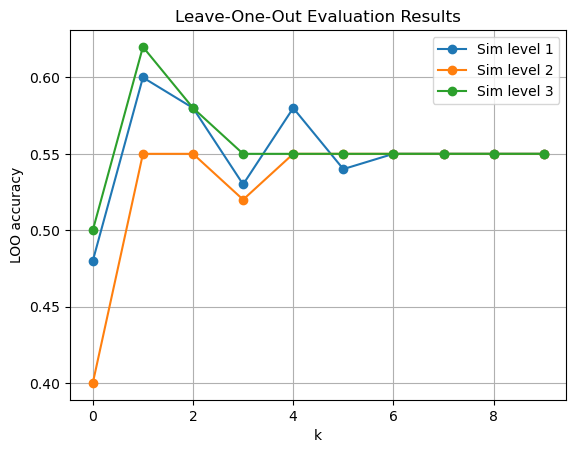

In [36]:
# LOO evaluation
# Define list for each sim level
l1 = []
l2 = []
l3 = []
k = 10

for k in range(1, k+1): 
    tic = time.time()
    mu = generate_capacity(enumerate_permute(x[0].unsqueeze(0))[0])

    print(f"Leave one out avec k = {k}")
    
    # SimLevel1
    res = FuzzLOO(
            C = KNNFuzz(input_dimension=x.size(1),mu=mu, k=k, sim=S1), 
            DS = (x, label),
            mu=mu
        )
    l1.append(res)
    print(f"SimLevel1: {res}")
    # Sim level 2
    res = FuzzLOO(
            C = KNNFuzz(input_dimension=x.size(1),mu=mu, k=k, sim=S2), 
            DS = (x, label),
            mu=mu
        )
    l2.append(res)
    print(f"SimLevel2: {res}")

    # Sim level 3
    res = FuzzLOO(
            C = KNNFuzz(input_dimension=x.size(1),mu=mu, k=k, sim=S3), 
            DS = (x, label),
            mu=mu
        )
    l3.append(res)
    print(f"SimLevel3: {res}\n")

    toc = time.time()
    print(f"Result in {(toc-tic):0.4f} seconds.")

# Plot results
plt.plot(l1, label="Sim level 1", marker='o')
plt.plot(l2, label="Sim level 2", marker='o')
plt.plot(l3, label="Sim level 3", marker='o')

# Config additional params
plt.ylabel("LOO accuracy")
plt.xlabel("k")
plt.title("Leave-One-Out Evaluation Results")
plt.grid()
plt.legend()